# Notebook Approche Supervisée

In [304]:
from sklearn.ensemble import RandomForestClassifier
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import mlflow.sklearn
import pandas as pd
import seaborn as sns
import mlflow
import re
import time

def create_confusion_matrix(conf_matrix, path):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix - Combined Pipeline')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig(path)
    plt.show()

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_params):
    with mlflow.start_run():
        # Paramètres du modèle
        for key, value in model_params.items():
            mlflow.log_param(key, value)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.sklearn.log_model(model, "model")

def train_and_evaluate(X, y):
    mlflow.start_run()
    param_max_depth = 10
    param_n_estimators = 100

    # enregistrez les paramètres
    mlflow.log_param("max_depth", param_max_depth)
    mlflow.log_param("n_estimators", param_n_estimators)

    model = RandomForestClassifier(max_depth=param_max_depth, n_estimators=param_n_estimators)
    model.fit(X, y)
    y_pred = model.predict(X)

    accuracy = accuracy_score(y, y_pred)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.sklearn.log_model(model, "model")
    mlflow.end_run()

def evaluate_and_log_metrics(experiment_name, model_name, model_type, y_test, y_predicted, training_time = None):

    experiment = mlflow.get_experiment_by_name(experiment_name)
    if experiment is None:
        mlflow.create_experiment(experiment_name)
        experiment = mlflow.get_experiment_by_name(experiment_name)

    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')

    with mlflow.start_run(experiment_id=experiment.experiment_id):
        mlflow.log_param("model_type", model_type)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        if (training_time != None):
            mlflow.log_metric("training_time", training_time)

        # enregistrer le modèle dans le registre MLFlow
        model_uri = f"runs:/{mlflow.active_run().info.run_id}/model"
        mlflow.register_model(model_uri, model_name)
        
        # Passer le modèle en staging
        switch_model_to_staging(mlflow, model_name)
    return accuracy, precision, recall, f1

def switch_model_to_staging(mlflow, model_name):
    client = mlflow.tracking.MlflowClient()
    model_version_details = client.get_latest_versions(model_name, stages=["None"])[0]
    
    client.transition_model_version_stage(
        name=model_name,
        version=model_version_details.version,
        stage="Staging"
    )

def plot_monthly_metrics(accuracies, precisions, recalls, f1_scores, months, file_path):
    plt.figure(figsize=(12, 6))
    plt.plot(months, accuracies, label='Accuracy', marker='o')
    plt.plot(months, precisions, label='Precision', marker='s')
    plt.plot(months, recalls, label='Recall', marker='^')
    plt.plot(months, f1_scores, label='F1 Score', marker='d')

    plt.xlabel('Months')
    plt.ylabel('Metrics')
    plt.title('Monthly Performance Metrics')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(file_path)
    plt.show()
    plt.close()

def preprocess_text(text):
    text = lowercase_text(text)
    text = remove_urls(text)
    # Tokenization
    word_tokens = tokenization(text)
    word_tokens = clear_ponctuation(word_tokens)
    # custom clean
    word_tokens = custom_clean(word_tokens)
    # Lemmatisation
    lemmatized_words = lemmatization(word_tokens)
    # suppression des stopwords
    return remove_stopwords(lemmatized_words)

def remove_urls(text):
    regex = r'https?://\S+|www\.\S+'
    text = re.sub(regex, '', text)
    return text

def custom_clean(text):
    # remplacer les sauts de lignes par des espaces
    word_tokens = [word_token.replace('\n', ' ') for word_token in text]
    # supprimer les espaces en trop
    word_tokens = [re.sub(r'\s+', ' ', phrase) for phrase in word_tokens]
    return word_tokens

def lowercase_text(text):
    return text.lower()

def tokenization(text):
    return sent_tokenize(text)

def lemmatization(word_tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in word_tokens]

def lemmatize_and_flatten(phrases):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for phrase in phrases for word in ' '.join(phrase).split()]

def remove_stopwords(sentences):
    stop_words = set(stopwords.words('english'))
    result = []
    for sentence in sentences:
        words = sentence.split()
        filtered_words = [word for word in words if word.lower() not in stop_words]
        result.append(' '.join(filtered_words))
    return result

def clear_ponctuation(text):
    return [re.sub(r'[^a-zA-Z0-9\s]', '', phrase) for phrase in text]

def extract_text_from_body(html_body):
    soup = BeautifulSoup(html_body, 'html.parser')
    return soup.get_text()

def transform_tags(tags_string):
    tags = re.findall(r'<(.*?)>', tags_string)
    cleaned_tags = ','.join(tags)
    return cleaned_tags


In [305]:
from sklearn.model_selection import train_test_split

data = pd.read_csv("dataset_cleaned.csv")

data['creationdate'] = pd.to_datetime(data['creationdate'])

train_data, test_data = train_test_split(data, test_size=0.3)

print(len(test_data))
print(len(train_data))

train_data_filtered = train_data[train_data['creationdate'] < pd.Timestamp('2023-01-01')]

test_data_filtered = test_data[test_data['creationdate'] < pd.Timestamp('2023-01-01')]

X_train = train_data_filtered[['title_lemmatized', 'body_lemmatized', 'creationdate']]
y_train_original = train_data_filtered['tags_transformed']

X_test = test_data_filtered[['title_lemmatized', 'body_lemmatized', 'creationdate']]
y_test_original = test_data_filtered['tags_transformed']

13609
31753


## MultiLabelBinarizer (Pour Entrainer le modèle sur les 100 tags les plus fréquents)

In [306]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from collections import Counter

y_train_lists = [tags_str.split(',') for tags_str in y_train_original]
y_test_lists = [tags_str.split(',') for tags_str in y_test_original]
tag_counts = Counter(tag for tags_list in y_train_lists for tag in tags_list)

# Garder les 100 tags les plus fréquents
N = 100
top_tags = [tag for tag, _ in tag_counts.most_common(N)]

# Convertir les listes de tags en représentation binaire
mlb = MultiLabelBinarizer(classes=top_tags)
y_train = mlb.fit_transform(y_train_lists)
y_test = mlb.transform(y_test_lists)

print(y_train.shape)
print(y_test.shape)

(31711, 100)
(13599, 100)


/Users/flo/workspace/Catégorisez automatiquement des questions/my_env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['.a', '.app', '.class-file', '.d.ts', '.hgtags', '.htaccess', '.net-1.1', '.net-2.0', '.net-3.5', '.net-4.0', '.net-4.5', '.net-4.6', '.net-4.7.2', '.net-4.8', '.net-5', '.net-6.0', '.net-7.0', '.net-assembly', '.net-core', '.net-core-2.0', '.net-core-2.1', '.net-core-2.2', '.net-core-3.0', '.net-core-3.1', '.net-core-rc2', '.net-framework-version', '.net-internals', '.net-mac', '.net-standard', '.net-standard-1.5', '.net-standard-2.0', '.net-standard-2.1', '.netrc', '.profile', '.so', '.when', '128-bit', '16-bit', '2-way-object-databinding', '2d', '3-tier', '32-bit', '32bit-64bit', '3d', '3d-model', '3d-modelling', '3d-reconstruction', '3des', '3dtouch', '3g', '64-bit', '7zip', 'a-star', 'aac', 'aadhaar', 'aapt', 'aar', 'abaddressbook', 'abap', 'abbr', 'abc', 'abcl', 'abi', 'abort', 'abrecord', 'absolute', 'absolute-pat

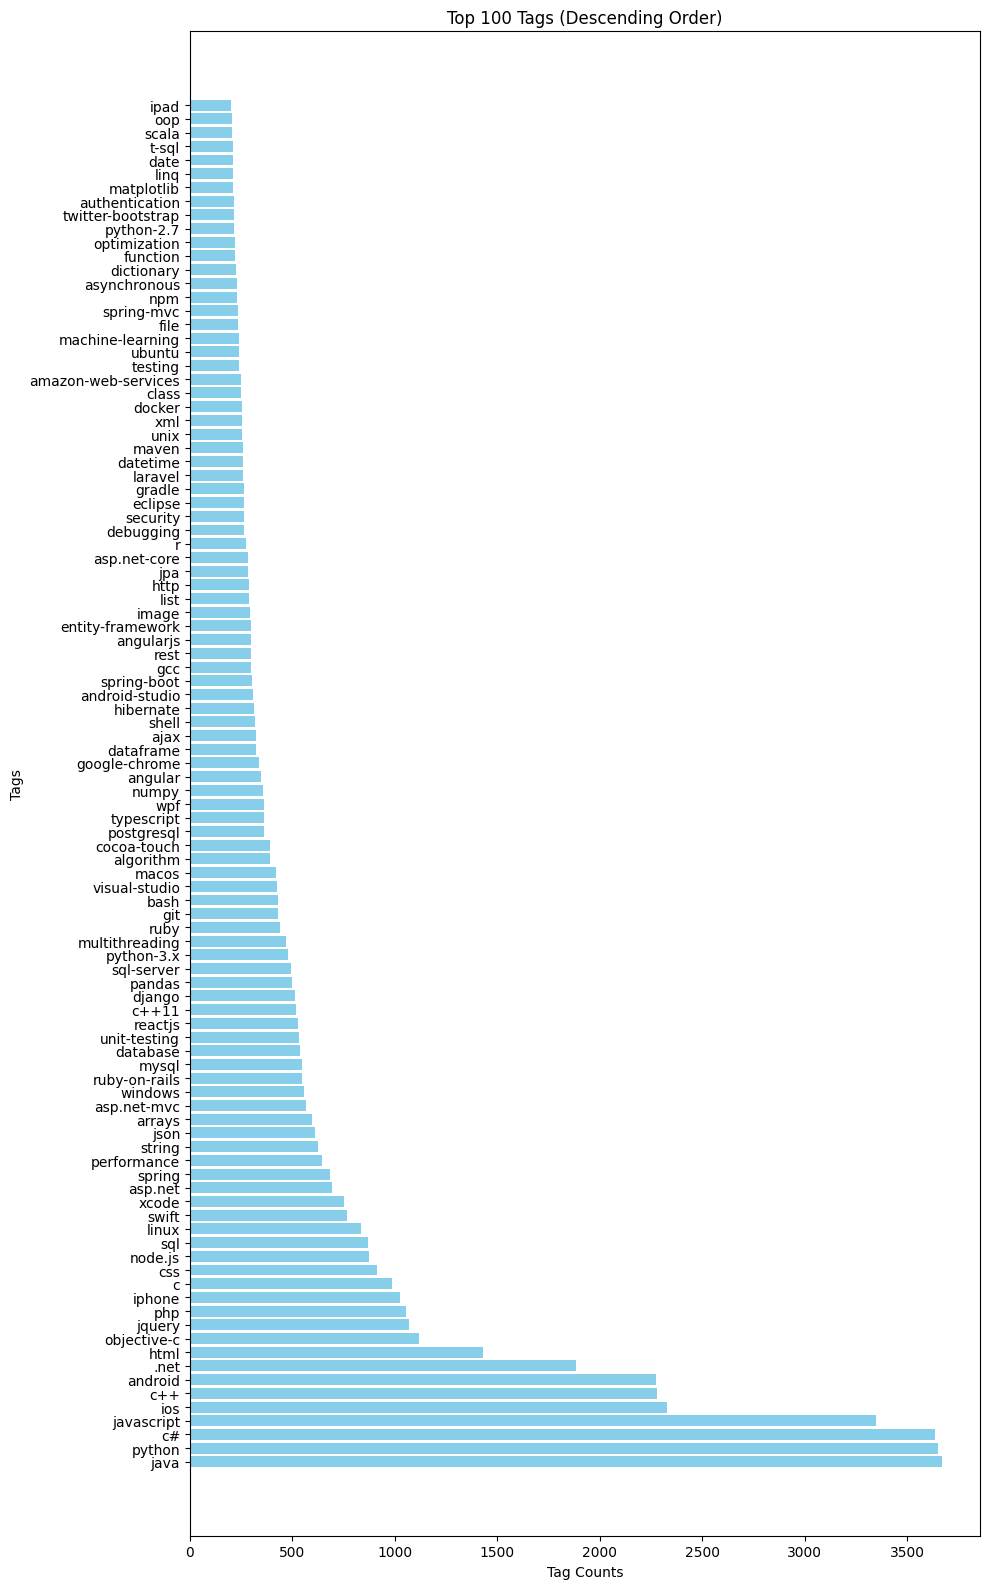

In [307]:
import matplotlib.pyplot as plt
from collections import Counter

top_tag_counts = Counter(tag for tags_list in y_train_lists for tag in tags_list if tag in top_tags)
top_tag_names, top_tag_counts = zip(*top_tag_counts.items())

sorted_indices = sorted(range(len(top_tag_counts)), key=lambda k: top_tag_counts[k], reverse=True)
top_tag_names = [top_tag_names[i] for i in sorted_indices]
top_tag_counts = [top_tag_counts[i] for i in sorted_indices]

plt.figure(figsize=(10, 16))
plt.barh(top_tag_names, top_tag_counts, color='skyblue')
plt.xlabel('Tag Counts')
plt.ylabel('Tags')
plt.title('Top {} Tags (Descending Order)'.format(N))
plt.tight_layout()

plt.show()


## CountVectorizer

### Train OneVsRestClassifier

In [308]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

title_classifier = MultinomialNB()
body_classifier = MultinomialNB()
combined_classifier = MultinomialNB()

titleOneRestclassifier = OneVsRestClassifier(title_classifier)
bodyOneRestclassifier = OneVsRestClassifier(body_classifier)
combinedOneRestclassifier = OneVsRestClassifier(combined_classifier)

title_pipeline = Pipeline([
    ('vectorizer_title', CountVectorizer()),
    ('classifier', titleOneRestclassifier)
])

body_pipeline = Pipeline([
    ('vectorizer_body', CountVectorizer()),
    ('classifier', bodyOneRestclassifier)
])

combined_pipeline = Pipeline([
    ('vectorizer_combined', CountVectorizer()),
    ('classifier', combinedOneRestclassifier)
])

X_train_combined = X_train['title_lemmatized'] + ' ' + X_train['body_lemmatized']
X_test_combined = X_test['title_lemmatized'] + ' ' + X_test['body_lemmatized']

title_pipeline.fit(X_train['title_lemmatized'], y_train)
body_pipeline.fit(X_train['body_lemmatized'], y_train)
combined_pipeline.fit(X_train_combined, y_train)

Pipeline(steps=[('vectorizer_combined', CountVectorizer()),
                ('classifier', OneVsRestClassifier(estimator=MultinomialNB()))])

### Predict OneVsRestClassifier

In [309]:
import numpy as np

X_title_test_transformed = title_pipeline.named_steps['vectorizer_title'].transform(X_test['title_lemmatized'])
X_body_test_transformed = body_pipeline.named_steps['vectorizer_body'].transform(X_test['body_lemmatized'])
X_combined_test_transformed = combined_pipeline.named_steps['vectorizer_combined'].transform(X_test_combined)

predictions_proba_title = title_pipeline.predict_proba(X_test['title_lemmatized'])
predictions_proba_body = body_pipeline.predict_proba(X_test['body_lemmatized'])
predictions_proba_combined = combined_pipeline.predict_proba(X_test_combined)

n_top_classes = 5

top_classes_indices_title = np.argsort(predictions_proba_title)[:, -n_top_classes:]
top_classes_indices_body = np.argsort(predictions_proba_body)[:, -n_top_classes:]
top_classes_indices_combined = np.argsort(predictions_proba_combined)[:, -n_top_classes:]

top_tags_title = mlb.classes_[top_classes_indices_title]
top_tags_body = mlb.classes_[top_classes_indices_body]
top_tags_combined = mlb.classes_[top_classes_indices_combined]


## Sauvegarde du modèle

In [310]:
from joblib import dump
import shutil

pipeline_file = 'oneVsRestClassifier_mlb_model.joblib'
mlb_file = 'mlb_model.joblib'

dump(combined_pipeline, pipeline_file)
dump(mlb, mlb_file)

destination_folder = '../api/app/models_src'

shutil.copy(pipeline_file, destination_folder)
shutil.copy(mlb_file, destination_folder)

'../api/app/models_src/mlb_model.joblib'

## Récupérer les tags les plus proches (en utilisant predict_proba)

In [311]:
# Liste des questions à prédire (title + body)
questions_to_predict = ["How can you implement a thread-safe singleton in Java?", "#*Whatnot** is a livestream shopping platform and marketplace backed by Andreessen Horowitz, Y Combinator, and CapitalG. We’re building the future of ecommerce, bringing together community, shopping and entertainment. We are committed to our values, whether working remotely or from one of our offices. We are building a team that has experience from top tech, retail and payments platforms in the world. We’re innovating in the fast-paced world of live auctions in categories including sports, fashion, video games, and streetwear. The platform couples rigorous seller vetting with a focus on community to create a welcoming space for buyers and sellers to share their passions with others. And, we’re growing. Whatnot has been the fastest growing marketplace in the US over the past two years and we’re hiring forward-thinking problem solvers across all functional areas. Retail disruption is one of the largest opportunities in the startup space today. Livestream shopping is taking off around the world – a $300B GMV market in China that’s grown 100% YoY. Whatnot is bringing it to the world through a community-first approach, starting in the U.S. where retail is a $5T market opportunity! We are looking for intellectually curious, highly motivated individuals to join us for a 12-week remote internship during summer 2024. Our interns work in cross-functional multidisciplinary teams enabling you to directly impact the direction of our platform. Your code and ideas will contribute to solving some of the most complex technical challenges we face today and define future engineering initiatives.    - Building new features for users in our live-streams - Implementing growth tactics and strategies to scale our buyer and seller flows - Building systems at scale that help us deliver a high trust marketplace experience By the end of your internship, you will have contributed to one of the fastest growing marketplaces ever while gaining core industry skills of project ideation, management and collaboration Curious about who thrives at Whatnot? We’ve found that low ego, a growth mindset, and leaning into action and high impact goes a long way here. As our next Engineering Intern you should have some industry software engineering experience, plus: - Pursuing a degree in computer science or other related major graduating in 2025 - Problem solver and out-of-the-box thinker - Willing to take risks and build product and systems for 1M+ users    - Ability to pick up on new technologies quickly"]

predictions_proba_combined_multiple = combined_pipeline.predict_proba(questions_to_predict)
n_top_classes = 5

for i, question in enumerate(questions_to_predict):
    top_classes_indices = predictions_proba_combined_multiple.argsort(axis=1)[:, -n_top_classes:][i]
    top_classes_probabilities = predictions_proba_combined_multiple[i, top_classes_indices]

    # Tri des classes et des probabilités par ordre décroissant de probabilité
    sorted_indices = np.argsort(top_classes_probabilities)[::-1]
    top_tags_combined_sorted = mlb.classes_[top_classes_indices[sorted_indices]]
    top_classes_probabilities_sorted = top_classes_probabilities[sorted_indices]

    print(f"Tags associés pour la question '{question}':", list(zip(top_tags_combined_sorted, top_classes_probabilities_sorted)))
    print("\n")


Tags associés pour la question 'How can you implement a thread-safe singleton in Java?': [('java', 0.8709142406163393), ('c#', 0.04281110199770818), ('multithreading', 0.02056481055494254), ('c++', 0.011360431210183373), ('android', 0.00353009384956873)]


Tags associés pour la question '#*Whatnot** is a livestream shopping platform and marketplace backed by Andreessen Horowitz, Y Combinator, and CapitalG. We’re building the future of ecommerce, bringing together community, shopping and entertainment. We are committed to our values, whether working remotely or from one of our offices. We are building a team that has experience from top tech, retail and payments platforms in the world. We’re innovating in the fast-paced world of live auctions in categories including sports, fashion, video games, and streetwear. The platform couples rigorous seller vetting with a focus on community to create a welcoming space for buyers and sellers to share their passions with others. And, we’re growing.

## Évaluation du modèle de référence

In [312]:
top_tags_title_predicted = mlb.transform(top_tags_title)
top_tags_body_predicted = mlb.transform(top_tags_body)
top_tags_combined_predicted = mlb.transform(top_tags_combined)
experiment_name = 'MultinomialNB'
model_name = 'MultinomialNB'

accuracy_title, precision_title, recall_title, f1_title = evaluate_and_log_metrics(experiment_name, model_name, "title", y_test, top_tags_title_predicted)
print("\nTitle Pipeline Metrics (Top 5 classes):")
print("Accuracy:", accuracy_title)
print("Precision:", precision_title)
print("Recall:", recall_title)
print("F1 Score:", f1_title)

accuracy_body, precision_body, recall_body, f1_body = evaluate_and_log_metrics(experiment_name, model_name, "body", y_test, top_tags_body_predicted)
print("\nBody Pipeline Metrics (Top 5 classes):")
print("Accuracy:", accuracy_body)
print("Precision:", precision_body)
print("Recall:", recall_body)
print("F1 Score:", f1_body)

accuracy_combined, precision_combined, recall_combined, f1_combined = evaluate_and_log_metrics(experiment_name, model_name, "combined", y_test, top_tags_combined_predicted)
print("\nCombined Pipeline Metrics (Top 5 classes):")
print("Accuracy:", accuracy_combined)
print("Precision:", precision_combined)
print("Recall:", recall_combined)
print("F1 Score:", f1_combined)


Registered model 'MultinomialNB' already exists. Creating a new version of this model...
Created version '94' of model 'MultinomialNB'.
/var/folders/cg/0gx_zldn535fk5xp_qrwk8wr0000gn/T/ipykernel_10647/3576892574.py:85: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.9.2/model-registry.html#migrating-from-stages
  model_version_details = client.get_latest_versions(model_name, stages=["None"])[0]
/var/folders/cg/0gx_zldn535fk5xp_qrwk8wr0000gn/T/ipykernel_10647/3576892574.py:87: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlfl


Title Pipeline Metrics (Top 5 classes):
Accuracy: 0.0013236267372600927
Precision: 0.35946426683943483
Recall: 0.6938737462246914
F1 Score: 0.4176168965834016


Registered model 'MultinomialNB' already exists. Creating a new version of this model...
Created version '95' of model 'MultinomialNB'.
/var/folders/cg/0gx_zldn535fk5xp_qrwk8wr0000gn/T/ipykernel_10647/3576892574.py:85: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.9.2/model-registry.html#migrating-from-stages
  model_version_details = client.get_latest_versions(model_name, stages=["None"])[0]
/var/folders/cg/0gx_zldn535fk5xp_qrwk8wr0000gn/T/ipykernel_10647/3576892574.py:87: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlfl


Body Pipeline Metrics (Top 5 classes):
Accuracy: 0.00036767409368335905
Precision: 0.3853251570010396
Recall: 0.5487900369141281
F1 Score: 0.3102374964028061

Combined Pipeline Metrics (Top 5 classes):
Accuracy: 0.00036767409368335905
Precision: 0.3938553426167569
Recall: 0.5921548156157947
F1 Score: 0.3449080938731637


Registered model 'MultinomialNB' already exists. Creating a new version of this model...
Created version '96' of model 'MultinomialNB'.
/var/folders/cg/0gx_zldn535fk5xp_qrwk8wr0000gn/T/ipykernel_10647/3576892574.py:85: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.9.2/model-registry.html#migrating-from-stages
  model_version_details = client.get_latest_versions(model_name, stages=["None"])[0]
/var/folders/cg/0gx_zldn535fk5xp_qrwk8wr0000gn/T/ipykernel_10647/3576892574.py:87: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlfl

## Évaluations du modèle par mois

- Période de références, toutes les données avant jusqu'à fin décembre 2022.
- On entraine le modèle une seule fois sur la période de référence.
- On compare les résultats du modèle par mois (chaque mois de 2023) par rapport aux résultats de référence.

### Creation de monthly_test_data avec les données de chaque mois

In [313]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec
from sklearn.model_selection import KFold

class GenericVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, vectorizer_func):
        self.vectorizer_func = vectorizer_func

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([self.vectorizer_func(text) for text in X])

def word2vec_vectorize(text, model):
    words = [word for word in text.split() if word in model.wv]
    if len(words) >= 1:
        return np.mean(model.wv[words], axis=0)
    else:
        return np.zeros(model.vector_size)

def bert_vectorize(texts, model_name='bert-base-uncased', max_length=128):
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name)
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
    return cls_embeddings

def bert_vectorize_2(texts, model_name='bert-base-uncased'):
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name)

    # Tokenisation du texte
    tokenized_texts = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

    with torch.no_grad():
        outputs = model(**tokenized_texts)

    # récupération de la sortie du dernier état caché
    last_hidden_states = outputs.last_hidden_state

    # moyenne des embeddings de chaque token pour obtenir un embedding de phrase
    sentence_embeddings = torch.mean(last_hidden_states, dim=1)

    return sentence_embeddings

def use_vectorize(text):
    embeddings = use_embed(text)
    return embeddings.numpy()

def custom_cross_validate(pipeline, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits)
    scores = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    }

    y = pd.DataFrame(y)

    for train_index, test_index in kf.split(X):

        X_train_cross, X_test_cross = X.iloc[train_index], X.iloc[test_index]
        y_train_cross, y_test_cross = y.iloc[train_index], y.iloc[test_index]
        
        pipeline.fit(X_train_cross, y_train_cross)
        predictions = pipeline.predict_proba(X_test_cross)

        n_top_classes = 5

        top_classes_indices_combined = np.argsort(predictions)[:, -n_top_classes:]
        top_tags_combined = mlb.classes_[top_classes_indices_combined]
        top_tags_combined_predicted = mlb.transform(top_tags_combined)

        scores['accuracy'].append(accuracy_score(y_test_cross, top_tags_combined_predicted))
        scores['precision'].append(precision_score(y_test_cross, top_tags_combined_predicted, average='micro'))
        scores['recall'].append(recall_score(y_test_cross, top_tags_combined_predicted, average='micro'))
        scores['f1'].append(f1_score(y_test_cross, top_tags_combined_predicted, average='micro'))

    return {metric: np.mean(values) for metric, values in scores.items()}


In [314]:
data = pd.read_csv("dataset_cleaned.csv")
data['creationdate'] = pd.to_datetime(data['creationdate'])

test_data_only_2023 = data[data['creationdate'] >= pd.Timestamp('2022-01-01')]
test_data_only_2023.to_csv("dataset_over_months_2023.csv", index=False)


In [315]:
print(len(test_data_only_2023))
monthly_test_data = {}
for month in range(1, 13):
    monthly_data = test_data_only_2023[test_data_only_2023['creationdate'].dt.year == 2022]
    monthly_data = monthly_data[monthly_data['creationdate'].dt.month == month]

    if not monthly_data.empty:
        monthly_test_data[month] = monthly_data

for month, data in monthly_test_data.items():
    print(f"Nombre de lignes pour le mois {month}: {len(data)}")


284
Nombre de lignes pour le mois 1: 36
Nombre de lignes pour le mois 2: 23
Nombre de lignes pour le mois 3: 25
Nombre de lignes pour le mois 4: 26
Nombre de lignes pour le mois 5: 23
Nombre de lignes pour le mois 6: 19
Nombre de lignes pour le mois 7: 21
Nombre de lignes pour le mois 8: 7
Nombre de lignes pour le mois 9: 16
Nombre de lignes pour le mois 10: 14
Nombre de lignes pour le mois 11: 12
Nombre de lignes pour le mois 12: 10


### Prédiction sur chaque mois

In [316]:
import numpy as np
import calendar

n_top_classes = 5
accuracy_combined = []
precision_combined = []
recall_combined = []
f1_combined = []
months = []

for month, X_test_month in monthly_test_data.items():
    month_name = calendar.month_name[month]
    months.append(month_name)
    experiment_name = f"{month_name} 2022 - MultinomialNB"
    model_name = "MultinomialNB"

    # préparation des données combinées pour le mois
    X_test_combined_month = X_test_month['title_lemmatized'] + ' ' + X_test_month['body_lemmatized']
    y_test_lists = [tags_str.split(',') for tags_str in X_test_month['tags_transformed']]
    y_test_month = mlb.transform(y_test_lists)
    
    # prédiction avec le modèle de référence (en utilisant predict_proba)
    predictions_proba_combined = combined_pipeline.predict_proba(X_test_combined_month)
    top_classes_indices_combined = np.argsort(predictions_proba_combined)[:, -n_top_classes:]
    top_tags_combined = mlb.classes_[top_classes_indices_combined]
    top_tags_combined_predicted = mlb.transform(top_tags_combined)

    # évaluation des performances pour le mois
    accuracy_combined_month, precision_combined_month, recall_combined_month, f1_combined_month = evaluate_and_log_metrics(
        experiment_name, model_name, f"combined_{month}", y_test_month, top_tags_combined_predicted)

    accuracy_combined.append(accuracy_combined_month)
    precision_combined.append(precision_combined_month)
    recall_combined.append(recall_combined_month)
    f1_combined.append(f1_combined_month)

    # métriques pour le mois
    print(f"\nCombined Pipeline Metrics for {month_name}:")
    print("Accuracy:", accuracy_combined_month)
    print("Precision:", precision_combined_month)
    print("Recall:", recall_combined_month)
    print("F1 Score:", f1_combined_month)


/Users/flo/workspace/Catégorisez automatiquement des questions/my_env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['.net-5', '.net-6.0', '.net-core', 'abc', 'adb', 'amazon-eks', 'amazon-iam', 'android-11', 'android-12', 'android-architecture-navigation', 'android-build', 'android-gradle-plugin', 'android-manifest', 'android-pendingintent', 'android-safe-args', 'android-studio-bumblebee', 'binding', 'build.gradle', 'c++-concepts', 'c++20', 'centos', 'centos7', 'commonjs', 'conda', 'dagger-hilt', 'data-munging', 'data-visualization', 'data-wrangling', 'django-settings', 'ecmascript-2020', 'eksctl', 'eslint', 'eslintrc', 'exoplayer2.x', 'ffmpeg', 'firebase-performance', 'flutter', 'fold-expression', 'github', 'google-analytics', 'google-analytics-4', 'google-chrome-devtools', 'google-play', 'google-play-console', 'homebrew', 'inspect', 'installed-applications', 'integer-division', 'kapt', 'kotlin', 'kubernetes', 'manjaro', 'math', 'mong


Combined Pipeline Metrics for January:
Accuracy: 0.0
Precision: 0.46162909731021184
Recall: 0.7647058823529411
F1 Score: 0.5255155837995023

Combined Pipeline Metrics for February:
Accuracy: 0.0
Precision: 0.5006345506345506
Recall: 0.7948717948717948
F1 Score: 0.5613529632760402


/Users/flo/workspace/Catégorisez automatiquement des questions/my_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/flo/workspace/Catégorisez automatiquement des questions/my_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/flo/workspace/Catégorisez automatiquement des questions/my_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to contr


Combined Pipeline Metrics for March:
Accuracy: 0.0
Precision: 0.4535121798279694
Recall: 0.7435897435897436
F1 Score: 0.46408362350253274

Combined Pipeline Metrics for April:
Accuracy: 0.0
Precision: 0.4752810981812193
Recall: 0.7391304347826086
F1 Score: 0.501784427346853


/var/folders/cg/0gx_zldn535fk5xp_qrwk8wr0000gn/T/ipykernel_10647/3576892574.py:87: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.9.2/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(
/Users/flo/workspace/Catégorisez automatiquement des questions/my_env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['amazon-eks', 'android-billing', 'android-gradle-plugin', 'android-jetpack', 'android-jetpack-compose', 'android-jetpack-compose-list', 'android-permissions', 'android-recyclerview', 'apache-kafka', 'assembly', 'aws-cli', 'babel-jest', 'build.gradle', 'circleci', 'cocoapods', 'compiler-errors', 'compose-recomposition', 'confluent-kafka-python', 'cpu-architecture',


Combined Pipeline Metrics for May:
Accuracy: 0.0
Precision: 0.5355358810190742
Recall: 0.8571428571428571
F1 Score: 0.615079365079365

Combined Pipeline Metrics for June:
Accuracy: 0.0
Precision: 0.5522685647685648
Recall: 0.8409090909090909
F1 Score: 0.609329351575341


/Users/flo/workspace/Catégorisez automatiquement des questions/my_env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['android-intent', 'android-tiramisu', 'apple-m1', 'approximate', 'autoprefixer', 'browser-automation', 'chromium', 'complex-numbers', 'console', 'dependency-management', 'deprecation-warning', 'eslint', 'expo', 'firebase', 'floating-point', 'flutter', 'flyway', 'google-analytics', 'google-chrome-devtools', 'immutability', 'intellij-idea', 'kotlin', 'navigation', 'opera', 'pnpm', 'postcss', 'priority-inversion', 'python-poetry', 'react-native', 'react-scripts', 'reference', 'selenium', 'selenium-chromedriver', 'selenium-webdriver', 'string-concatenation', 'structural-pattern-matching', 'swift-package-manager', 'swift5', 'typeerror', 'virtualenv', 'vite', 'warnings'] will be ignored
  warnings.warn(
/Users/flo/workspace/Catégorisez automatiquement des questions/my_env/lib/python3.11/site-packages/sklearn/metrics/_classific


Combined Pipeline Metrics for July:
Accuracy: 0.0
Precision: 0.5228758169934641
Recall: 0.7941176470588235
F1 Score: 0.5494218200100552

Combined Pipeline Metrics for August:
Accuracy: 0.0
Precision: 0.5378787878787878
Recall: 0.9090909090909091
F1 Score: 0.6515151515151515


Created version '104' of model 'MultinomialNB'.
/var/folders/cg/0gx_zldn535fk5xp_qrwk8wr0000gn/T/ipykernel_10647/3576892574.py:85: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.9.2/model-registry.html#migrating-from-stages
  model_version_details = client.get_latest_versions(model_name, stages=["None"])[0]
/var/folders/cg/0gx_zldn535fk5xp_qrwk8wr0000gn/T/ipykernel_10647/3576892574.py:87: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.9.2/model-registry.html#migrating-from-stages
  client.transition_model_ve


Combined Pipeline Metrics for September:
Accuracy: 0.0
Precision: 0.4740864527629233
Recall: 0.7352941176470589
F1 Score: 0.5331369610781377

Combined Pipeline Metrics for October:
Accuracy: 0.0
Precision: 0.632799671592775
Recall: 0.7586206896551724
F1 Score: 0.626787580235856


/Users/flo/workspace/Catégorisez automatiquement des questions/my_env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['.net-7.0', 'aiohttp', 'amazon-s3', 'android-buildconfig', 'android-debug', 'arm64', 'assembly', 'aws-cdk', 'aws-lambda', 'clang', 'frontend', 'jetbrains-ide', 'llvm', 'macos-monterey', 'next.js', 'nuxt.js', 'pip', 'pycharm', 'pyenv', 'python-3.10', 'python-3.11', 'react-native', 'react-redux', 'redux', 'remix', 'rider', 'scikit-learn', 'server-side-rendering', 'tinymce', 'tsconfig', 'typescript-eslint', 'vue.js', 'wamp'] will be ignored
  warnings.warn(
/Users/flo/workspace/Catégorisez automatiquement des questions/my_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/flo/work


Combined Pipeline Metrics for November:
Accuracy: 0.0
Precision: 0.5746472663139329
Recall: 0.8148148148148148
F1 Score: 0.6176954732510288

Combined Pipeline Metrics for December:
Accuracy: 0.0
Precision: 0.5657467532467532
Recall: 0.9090909090909091
F1 Score: 0.6565656565656566


/Users/flo/workspace/Catégorisez automatiquement des questions/my_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/flo/workspace/Catégorisez automatiquement des questions/my_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/flo/workspace/Catégorisez automatiquement des questions/my_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to contr

## Graph de l'évolution du score à travers les mois

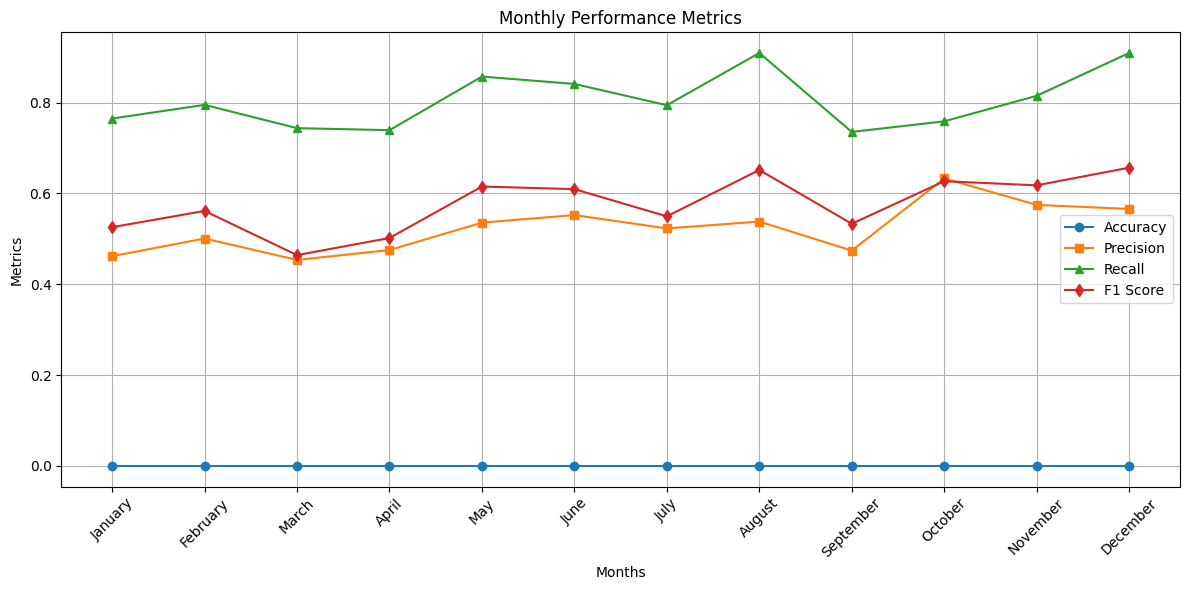

In [317]:
plot_monthly_metrics(accuracy_combined, precision_combined, recall_combined, f1_combined, months, 'scoring_over_time.png')

## Méthodes d'embedding

In [318]:
full_data = data['title_lemmatized'] + ' ' + data['body_lemmatized']

word2vec_model = Word2Vec(sentences=full_data.apply(lambda x: x.split()), vector_size=200, window=10, min_count=1, workers=4, epochs=20)

### Word2vec + Logistic Regression

In [319]:
pipeline_word2vec_logistic_regression = Pipeline([
    ('vectorizer', GenericVectorizer(lambda x: word2vec_vectorize(x, word2vec_model))),
    ('classifier', OneVsRestClassifier(LogisticRegression()))
])
start_time = time.time()
pipeline_word2vec_logistic_regression.fit(X_train_combined, y_train)
end_time = time.time()

training_time = end_time - start_time

print("Temps d'entrainement:", training_time, "secondes")

predictions_word2vec_logistic_regression = pipeline_word2vec_logistic_regression.predict_proba(X_test_combined)

Temps d'entrainement: 14.076939105987549 secondes


In [320]:
model_name = 'Word2vec - Logistic Regression'
experiment_name = 'Word2vec -Logistic Regression'

n_top_classes = 5

top_classes_indices_combined = np.argsort(predictions_word2vec_logistic_regression)[:, -n_top_classes:]
top_tags_combined = mlb.classes_[top_classes_indices_combined]
top_tags_combined_predicted = mlb.transform(top_tags_combined)

accuracy_combined, precision_combined, recall_combined, f1_combined = evaluate_and_log_metrics(experiment_name, model_name, "combined", y_test, top_tags_combined_predicted, training_time)

print("\nCombined Pipeline Metrics (Top 5 classes):")
print("Accuracy:", accuracy_combined)
print("Precision:", precision_combined)
print("Recall:", recall_combined)
print("F1 Score:", f1_combined)



Combined Pipeline Metrics (Top 5 classes):
Accuracy: 0.0
Precision: 0.04008222996986287
Recall: 0.2703680226704948
F1 Score: 0.06058248450985807


/Users/flo/workspace/Catégorisez automatiquement des questions/my_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Registered model 'Word2vec - Logistic Regression' already exists. Creating a new version of this model...
Created version '2' of model 'Word2vec - Logistic Regression'.
/var/folders/cg/0gx_zldn535fk5xp_qrwk8wr0000gn/T/ipykernel_10647/3576892574.py:85: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.9.2/model-registry.html#migrating-from-stages
  model_version_details = client.get_latest_versions(model_

In [321]:
cv_scores = custom_cross_validate(pipeline_word2vec_logistic_regression, X_train_combined, y_train, n_splits=5)

for metric, score in cv_scores.items():
    print(f"Moyenne {metric}: {score}")

Moyenne accuracy: 0.0
Moyenne precision: 0.10768496901085049
Moyenne recall: 0.272153563323391
Moyenne f1: 0.15431180253938018


### Word2vec + XGBClassifier

In [322]:
from xgboost import XGBClassifier

pipeline_word2vec_XGBoost = Pipeline([
    ('vectorizer', GenericVectorizer(lambda x: word2vec_vectorize(x, word2vec_model))),
    ('classifier', OneVsRestClassifier(XGBClassifier()))
])

start_time = time.time()
pipeline_word2vec_XGBoost.fit(X_train_combined, y_train)
end_time = time.time()

training_time = end_time - start_time

print("Temps d'entrainement:", training_time, "secondes")

predictions_word2vec_XGBoost = pipeline_word2vec_XGBoost.predict_proba(X_test_combined)

Temps d'entrainement: 135.19326400756836 secondes


In [323]:
model_name = 'Word2vec - XGBoost'
experiment_name = 'Word2vec - XGBoost'

n_top_classes = 5

top_classes_indices_combined = np.argsort(predictions_word2vec_XGBoost)[:, -n_top_classes:]
top_tags_combined = mlb.classes_[top_classes_indices_combined]
top_tags_combined_predicted = mlb.transform(top_tags_combined)

accuracy_combined, precision_combined, recall_combined, f1_combined = evaluate_and_log_metrics(experiment_name, model_name, "combined", y_test, top_tags_combined_predicted, training_time)

print("\nCombined Pipeline Metrics (Top 5 classes):")
print("Accuracy:", accuracy_combined)
print("Precision:", precision_combined)
print("Recall:", recall_combined)
print("F1 Score:", f1_combined)



Combined Pipeline Metrics (Top 5 classes):
Accuracy: 7.353481873667182e-05
Precision: 0.1691959944803442
Recall: 0.41597374995339126
F1 Score: 0.21618487889375668


Registered model 'Word2vec - XGBoost' already exists. Creating a new version of this model...
Created version '2' of model 'Word2vec - XGBoost'.
/var/folders/cg/0gx_zldn535fk5xp_qrwk8wr0000gn/T/ipykernel_10647/3576892574.py:85: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.9.2/model-registry.html#migrating-from-stages
  model_version_details = client.get_latest_versions(model_name, stages=["None"])[0]
/var/folders/cg/0gx_zldn535fk5xp_qrwk8wr0000gn/T/ipykernel_10647/3576892574.py:87: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: htt

In [324]:
cv_scores = custom_cross_validate(pipeline_word2vec_XGBoost, X_train_combined, y_train, n_splits=5)

for metric, score in cv_scores.items():
    print(f"Moyenne {metric}: {score}")

Moyenne accuracy: 6.30715862503942e-05
Moyenne precision: 0.16414491092194938
Moyenne recall: 0.414846587923852
Moyenne f1: 0.2352186769653423


### Bert + custom classification layer

In [325]:
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter

y_train_lists = [tags_str.split(',') for tags_str in y_train_original]
y_test_lists = [tags_str.split(',') for tags_str in y_test_original]
tag_counts = Counter(tag for tags_list in y_train_lists for tag in tags_list)

N = 100
top_tags = [tag for tag, _ in tag_counts.most_common(N)]

mlb = MultiLabelBinarizer(classes=top_tags)
y_train = mlb.fit_transform(y_train_lists)
y_test = mlb.transform(y_test_lists)

print(y_train.shape)
print(y_test.shape)

(31711, 100)
(13599, 100)


/Users/flo/workspace/Catégorisez automatiquement des questions/my_env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['.a', '.app', '.class-file', '.d.ts', '.hgtags', '.htaccess', '.net-1.1', '.net-2.0', '.net-3.5', '.net-4.0', '.net-4.5', '.net-4.6', '.net-4.7.2', '.net-4.8', '.net-5', '.net-6.0', '.net-7.0', '.net-assembly', '.net-core', '.net-core-2.0', '.net-core-2.1', '.net-core-2.2', '.net-core-3.0', '.net-core-3.1', '.net-core-rc2', '.net-framework-version', '.net-internals', '.net-mac', '.net-standard', '.net-standard-1.5', '.net-standard-2.0', '.net-standard-2.1', '.netrc', '.profile', '.so', '.when', '128-bit', '16-bit', '2-way-object-databinding', '2d', '3-tier', '32-bit', '32bit-64bit', '3d', '3d-model', '3d-modelling', '3d-reconstruction', '3des', '3dtouch', '3g', '64-bit', '7zip', 'a-star', 'aac', 'aadhaar', 'aapt', 'aar', 'abaddressbook', 'abap', 'abbr', 'abc', 'abcl', 'abi', 'abort', 'abrecord', 'absolute', 'absolute-pat

In [326]:
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn import DataParallel
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=100) 

class BertPipeline:
    def __init__(self, model):
        self.model = model
        self.threshold = 0.3
        self.optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
        self.loss_fn = torch.nn.BCEWithLogitsLoss() 

    def fit(self, X, y, epochs=6, batch_size=4):
        if torch.cuda.device_count() > 1: 
            print("Utilisation de", torch.cuda.device_count(), "GPUs pour l'entraînement.")
            self.model = DataParallel(self.model) 
        for epoch in range(epochs):
            epoch_loss = 0.0
            for i in range(0, len(X), batch_size):
                batch_texts = X[i:i+batch_size]
                batch_labels = torch.tensor(y[i:i+batch_size], dtype=torch.float32)

                inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt')
                labels = batch_labels 

                self.optimizer.zero_grad()  # Reset le gradient
                outputs = self.model(**inputs)
                logits = outputs.logits

                loss = self.loss_fn(logits, labels)
                loss.backward()  # Backpropagation
                self.optimizer.step() 

                epoch_loss += loss.item()

            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}")


    def predict(self, X):
        predictions = []
        class_counts = Counter(mlb.classes_)        
        N = 100
        top_classes = [class_name for class_name, _ in class_counts.most_common(N)]
        with torch.no_grad(): 
            for text in X:
                inputs = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
                outputs = self.model(**inputs)
                logits = outputs.logits
                probabilities = torch.sigmoid(logits).detach().numpy() 

                specific_class_indices = [mlb.classes_.tolist().index(cls) for cls in top_classes]
                specific_class_probabilities = probabilities[:, specific_class_indices]

                binary_predictions = (specific_class_probabilities >= self.threshold).astype(int) 
                predictions.append(binary_predictions)
        return np.squeeze(predictions)


# Define and instantiate the pipeline
pipeline_bert = BertPipeline(model)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(X_train['title_lemmatized'], y_train, test_size=0.2, random_state=42)

X_test_bert_formatted = []
X_train_bert_formatted = []

for document in X_test_bert:
    # concaténer toutes les phrases du document en une seule chaîne
    concatenated_document = ''.join([phrase.strip("[]'") for phrase in document])
    # ajouter le document formaté à la liste
    X_test_bert_formatted.append(concatenated_document)

for document in X_train_bert:
    concatenated_document = ''.join([phrase.strip("[]'") for phrase in document])
    X_train_bert_formatted.append(concatenated_document)


start_time = time.time()

pipeline_bert.fit(X_train_bert_formatted[:10000], y_train_bert[:10000])

end_time = time.time()
training_time = end_time - start_time
print("Temps d'entrainement:", training_time, "secondes")

Epoch 1/6, Loss: 261.15295424871147


In [ ]:
model_name = 'BERT - Custom classification layer'
experiment_name = 'BERT - Custom classification layer'

n_top_classes = 5

# Make predictions on the test data
predictions_bert = pipeline_bert.predict(X_test_bert_formatted[:500])

top_classes_indices_combined = np.argsort(predictions_bert)[:, -n_top_classes:]
top_tags_combined = mlb.classes_[top_classes_indices_combined]
top_tags_combined_predicted = mlb.transform(top_tags_combined)

accuracy_combined, precision_combined, recall_combined, f1_combined = evaluate_and_log_metrics(experiment_name, model_name, "title", y_test_bert[:500], top_tags_combined_predicted, training_time)

print("\nTitle Bert Metrics (Top 5 classes):")
print("Accuracy:", accuracy_combined)
print("Precision:", precision_combined)
print("Recall:", recall_combined)
print("F1 Score:", f1_combined)


### Use + Logistic Regression

In [ ]:
import tensorflow_hub as hub
from sklearn.preprocessing import FunctionTransformer

use_embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

pipeline_use_logistic_regression = Pipeline([
    ('vectorizer', FunctionTransformer(use_vectorize)),
    ('classifier', OneVsRestClassifier(LogisticRegression()))
])

start_time = time.time()
pipeline_use_logistic_regression.fit(X_train_combined, y_train)
end_time = time.time()
training_time = end_time - start_time
print("Temps d'entrainement:", training_time, "secondes")

predictions_use_logistic_regression = pipeline_use_logistic_regression.predict_proba(X_test_combined)


In [ ]:
model_name = 'Universal Sentence Encoder - Logistic Regression'
experiment_name = 'Universal Sentence Encoder - Logistic Regression'

n_top_classes = 5

top_classes_indices_combined = np.argsort(predictions_use_logistic_regression)[:, -n_top_classes:]
top_tags_combined = mlb.classes_[top_classes_indices_combined]
top_tags_combined_predicted = mlb.transform(top_tags_combined)

accuracy_combined, precision_combined, recall_combined, f1_combined = evaluate_and_log_metrics(experiment_name, model_name, "combined", y_test, top_tags_combined_predicted, training_time)

print("\nCombined Pipeline Metrics (Top 5 classes):")
print("Accuracy:", accuracy_combined)
print("Precision:", precision_combined)
print("Recall:", recall_combined)
print("F1 Score:", f1_combined)
print("Training time:", training_time)


In [ ]:
cv_scores = custom_cross_validate(pipeline_use_logistic_regression, X_train_combined, y_train, n_splits=5)

for metric, score in cv_scores.items():
    print(f"Moyenne {metric}: {score}")

## USE + Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.multiclass import OneVsRestClassifier
from joblib import Parallel, delayed

def transform_data(X):
    return FunctionTransformer(use_vectorize).transform(X)

X_train_transformed = transform_data(X_train_combined)
X_test_transformed = transform_data(X_test_combined)

def fit_pipeline(X, y):
    pipeline_use_svm = Pipeline([
        ('classifier', OneVsRestClassifier(RandomForestClassifier()))
    ])
    pipeline_use_svm.fit(X, y)
    return pipeline_use_svm

start_time = time.time()

# Parallélisation fit
classifiers = Parallel(n_jobs=-1)(delayed(fit_pipeline)(X_train_transformed, y_train[:, i]) for i in range(y_train.shape[1]))

end_time = time.time()
training_time = end_time - start_time
print("Temps d'entrainement:", training_time, "secondes")

predictions_use_svm = np.array([classifier.predict_proba(X_test_transformed)[:, 1] for classifier in classifiers]).T


In [ ]:
model_name = 'Universal Sentence Encoder - Random Forest'
experiment_name = 'Universal Sentence Encoder - Random Forest'

n_top_classes = 5

top_classes_indices_combined = np.argsort(predictions_use_svm)[:, -n_top_classes:]
top_tags_combined = mlb.classes_[top_classes_indices_combined]
top_tags_combined_predicted = mlb.transform(top_tags_combined)

accuracy_combined, precision_combined, recall_combined, f1_combined = evaluate_and_log_metrics(experiment_name, model_name, "combined", y_test, top_tags_combined_predicted, training_time)

print("\nCombined Pipeline Metrics (Top 5 classes):")
print("Accuracy:", accuracy_combined)
print("Precision:", precision_combined)
print("Recall:", recall_combined)
print("F1 Score:", f1_combined)
print("Training time:", training_time)

In [ ]:
cv_scores = custom_cross_validate(predictions_use_svm, X_train_combined, y_train, n_splits=5)

for metric, score in cv_scores.items():
    print(f"Moyenne {metric}: {score}")

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

def bert_vectorize(texts, model_name='bert-base-uncased', max_length=128):
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name)
    inputs = tokenizer(texts, padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
    return cls_embeddings

def vectorize_with_bert(texts, model_name='bert-base-uncased'):
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name)

    # Tokenisation du texte
    tokenized_texts = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

    with torch.no_grad():
        outputs = model(**tokenized_texts)

    # Récupération de la sortie du dernier état caché
    last_hidden_states = outputs.last_hidden_state

    # Moyenne des embeddings de chaque token pour obtenir un embedding de phrase
    sentence_embeddings = torch.mean(last_hidden_states, dim=1)

    return sentence_embeddings

texts = ['sslerrorssl1 operation failed within library',  'Le chat dort sur le tapis.']
embeddings = vectorize_with_bert(texts)

print(embeddings.shape)
